## Задание.


- реализовать один из алгоритмов RL (рекомендуем Q-learning, a.k.a. SARSAMAX);- 
реализовать логику обучения агента используя среду из Gymnasium
- 
решить задачу Taxi-v
- сделать небольшой отчет об обучении агента;
- рассчитайтеитывайте суммарную награду и среднюю награду за п 100 эпизодовэя агента.

Установим все необхоимые библиотеки. 

!pip install moviepy

Импортируем все необходмые библиотеки

In [30]:
import io
import base64

import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt

from moviepy.editor import ImageSequenceClip
from IPython.display import HTML


Выведем все необходимые параметры обучения в константы для проведения эксперриментов

In [60]:
# Параметры обучения
alpha = 0.011  # Темп обучения
gamma = 0.99  # Коэффициент дисконтирования
epsilon = 0.5  # Вероятность случайного действия (epsilon-greedy)
epsilon_min = 0.1
epsilon_decay = 0.995
num_episodes = 50000

Инициализация среды и Q-таблицы

In [64]:
env = gym.make('Taxi-v3')
state_size = env.observation_space.n
action_size = env.action_space.n

Реализация алгоритма Q-lerning

In [ ]:
Q_table = np.zeros((state_size, action_size))
def choose_action(state):
    if np.random.rand() <= epsilon:
        return np.random.choice(action_size)
    else:
        return np.argmax(Q_table[state])

# Обучение агента
rewards_qlearning = []
average_rewards_qlearning = []

for episode in range(num_episodes):
    state = env.reset()[0]
    total_reward = 0
    
    while True:
        action = choose_action(state)
        next_state, reward, done, _, _ = env.step(action)
        best_next_action = np.argmax(Q_table[next_state])
        Q_table[state, action] = Q_table[state, action] + alpha * (reward + gamma * Q_table[next_state, best_next_action] - Q_table[state, action])
        state = next_state
        total_reward += reward
        
        if done:
            break

    rewards_qlearning.append(total_reward)
    if episode >= 100:
        average_rewards_qlearning.append(np.mean(rewards_qlearning[-100:]))
    else:
        average_rewards_qlearning.append(np.mean(rewards_qlearning))

    epsilon = max(epsilon_min, epsilon * epsilon_decay)
    
    if episode % 100 == 0:
        print(f"Эпизод {episode}, Средняя награда за последние 100 эпизодов: {average_rewards_qlearning[-1]}")

# Сохранение обученного агента
np.save("Q_table.npy", Q_table)

Реализация алгоритма Sarsa 

In [ ]:
# Инициализация среды и Q-таблицы для SARSA
Q_table_sarsa = np.zeros((state_size, action_size))

# Обучение агента с использованием SARSA
rewards_sarsa = []
average_rewards_sarsa = []

for episode in range(num_episodes):
    state = env.reset()[0]
    total_reward = 0
    action = choose_action(state)
    
    while True:
        next_state, reward, done, _, _ = env.step(action)
        next_action = choose_action(next_state)
        Q_table_sarsa[state, action] = Q_table_sarsa[state, action] + alpha * (reward + gamma * Q_table_sarsa[next_state, next_action] - Q_table_sarsa[state, action])
        state = next_state
        action = next_action
        total_reward += reward
        
        if done:
            break

    rewards_sarsa.append(total_reward)
    if episode >= 100:
        average_rewards_sarsa.append(np.mean(rewards_sarsa[-100:]))
    else:
        average_rewards_sarsa.append(np.mean(rewards_sarsa))

    epsilon = max(epsilon_min, epsilon * epsilon_decay)
    
    if episode % 100 == 0:
        print(f"Эпизод {episode}, Средняя награда за последние 100 эпизодов: {average_rewards_sarsa[-1]}")

# Сохранение обученного агента
np.save("Q_table_sarsa.npy", Q_table_sarsa)

Построим графики увеличения вознаграждения за последние 100 эпизодов

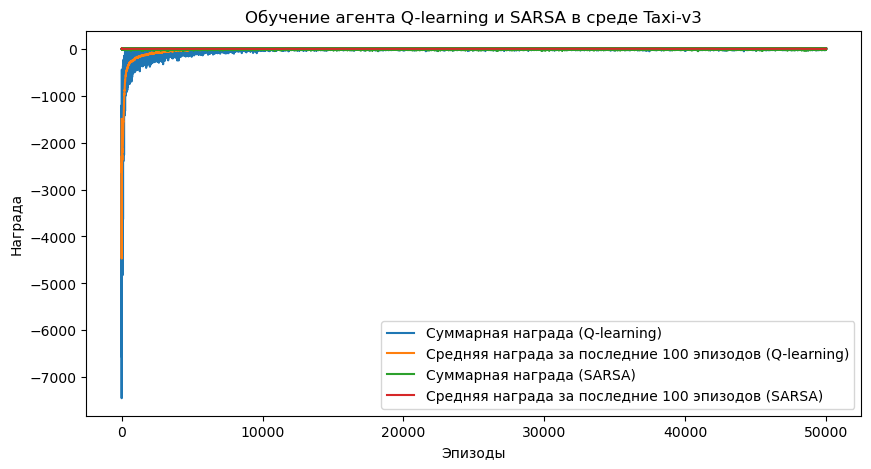

In [70]:
plt.figure(figsize=(10,5))
plt.plot(rewards_qlearning, label='Суммарная награда (Q-learning)')
plt.plot(average_rewards_qlearning, label='Средняя награда за последние 100 эпизодов (Q-learning)')
plt.plot(rewards_sarsa, label='Суммарная награда (SARSA)')
plt.plot(average_rewards_sarsa, label='Средняя награда за последние 100 эпизодов (SARSA)')
plt.xlabel('Эпизоды')
plt.ylabel('Награда')
plt.title('Обучение агента Q-learning и SARSA в среде Taxi-v3')
plt.legend()
plt.show()

Визуализация результатов для нагладности

In [72]:
# Инициализация среды и загрузка обученного агента
env = gym.make('Taxi-v3', render_mode='human')
Q_table = np.load("Q_table.npy")

def run_agent(env, Q_table, num_episodes=1, resize_factor=2):
    frames = []
    for episode in range(num_episodes):
        state = env.reset()[0]
        done = False
        while not done:
            action = np.argmax(Q_table[state])
            state, reward, done, _, _ = env.step(action)
            frame = env.render()
            if frame is not None:
                # Уменьшение разрешения кадра
                frame = frame[::resize_factor, ::resize_factor, :]
                frames.append(frame)
    return frames

# Запуск агента и запись кадров
frames = run_agent(env, Q_table)

# Закрытие среды
env.close()

# Фильтрация пустых кадров
frames = [frame for frame in frames if frame is not None]

# Проверка наличия кадров для создания видео
if frames:
    # Создание и сохранение видео
    clip = ImageSequenceClip(frames, fps=10)  # Указание значения fps
    clip.write_videofile("taxi_agent.mp4", codec='libx264')

    # Функция для отображения видео в Jupyter Lab
    def display_video(video_path):
        video = io.open(video_path, 'r+b').read()
        encoded = base64.b64encode(video)
        return HTML(data='''
            <video width="640" height="480" controls>
                <source src="data:video/mp4;base64,{0}" type="video/mp4"/>
            </video>'''.format(encoded.decode('ascii')))

    # Отображение видео
    display_video("taxi_agent.mp4")
else:
    print("Нет кадров для создания видео.")


Нет кадров для создания видео.


In [74]:
# Инициализация среды и загрузка обученного агента
env = gym.make('Taxi-v3', render_mode='human')
Q_table_sarsa = np.load("Q_table_sarsa.npy")

def run_agent(env, Q_table_sarsa, num_episodes=1, resize_factor=2):
    frames = []
    for episode in range(num_episodes):
        state = env.reset()[0]
        done = False
        while not done:
            action = np.argmax(Q_table[state])
            state, reward, done, _, _ = env.step(action)
            frame = env.render()
            if frame is not None:
                # Уменьшение разрешения кадра
                frame = frame[::resize_factor, ::resize_factor, :]
                frames.append(frame)
    return frames

# Запуск агента и запись кадров
frames = run_agent(env, Q_table_sarsa)

# Закрытие среды
env.close()

# Фильтрация пустых кадров
frames = [frame for frame in frames if frame is not None]

# Проверка наличия кадров для создания видео
if frames:
    # Создание и сохранение видео
    clip = ImageSequenceClip(frames, fps=10)  # Указание значения fps
    clip.write_videofile("taxi_agent.mp4", codec='libx264')

    # Функция для отображения видео в Jupyter Lab
    def display_video(video_path):
        video = io.open(video_path, 'r+b').read()
        encoded = base64.b64encode(video)
        return HTML(data='''
            <video width="640" height="480" controls>
                <source src="data:video/mp4;base64,{0}" type="video/mp4"/>
            </video>'''.format(encoded.decode('ascii')))

    # Отображение видео
    display_video("taxi_agent_sarsa.mp4")
else:
    print("Нет кадров для создания видео.")

Нет кадров для создания видео.


## Заключение

Выбор между Q-learning и SARSA зависит от целей обучения и требований к алгоритму. Q-learning часто используется в задачах с меньшим уклонением в сторону исследования (exploitation), в то время как SARSA более уравновешен между эксплорацией и эксплуатацией. В моем коде был реализованы оба алгоритма для задачи Taxi-v3.
Также я визуализироал работу данного алгоритма.